#Restaurant Reviews

##Introduction
The analysis here follows the one presented in RestaurantReviewsClassification.ipynb. 
In this notebook, the reviews are converted to embeddings vectors instead of count vectors in the previous case, and passed to a dense layer of Neural Net for binary classification.

In [ ]:
#Import
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import seaborn as sns 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
dataset = pd.read_csv('MyDrive/MLData/Restaurant_Reviews.tsv',delimiter='\t',
                      quoting=3)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
dataset.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [ ]:
dataset['Length']=dataset['Review'].apply(len)

In [ ]:
dataset

,Review,Liked,Length
0,Wow... Loved this place.,1,24
1,Crust is not good.,0,18
2,Not tasty and the texture was just nasty.,0,41
3,Stopped by during the late May bank holiday of...,1,87
4,The selection on the menu was great and so wer...,1,59
...,...,...,...
995,I think food should have flavor and texture an...,0,66
996,Appetite instantly gone.,0,24
997,Overall I was not impressed and would not go b...,0,50
998,"The whole experience was underwhelming, and I ...",0,91


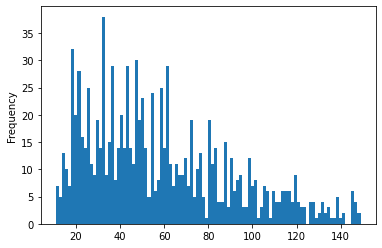

In [ ]:
#histogram
dataset['Length'].plot(bins=100,kind='hist')

**Cleaning text to reduce word vectors size by 1) removing 'stopwords' which are not very useful in meaning, 2) using only word stem, without the conjugation, case etc.**

In [ ]:
#Cleaning Text
import re, nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []
nsamples = len(dataset)

for i in range(nsamples):
  review = re.sub('[^a-zA-Z]',' ',dataset['Review'][i])
  review = review.lower()
  review = review.split()
  ps = PorterStemmer()
  all_stopwords = stopwords.words('english')
  all_stopwords.remove('not')
  review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
  review = ' '.join(review)
  corpus.append(review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
##Create Bag of Words Model
from sklearn.feature_extraction.text import CountVectorizer 
cv = CountVectorizer(max_features=1500)
corpus[0]

'wow love place'

In [ ]:
x = cv.fit_transform(corpus).toarray()
y = dataset.iloc[:,1]

In [ ]:
features= cv.get_feature_names_out()
print(len(features),'\n',features[0:20])

1500 
 ['absolut' 'absolutley' 'accid' 'accommod' 'accomod' 'accordingli'
 'account' 'ach' 'acknowledg' 'across' 'actual' 'ad' 'afford' 'afternoon'
 'ago' 'ahead' 'airlin' 'airport' 'ala' 'albondiga']


In [ ]:
#Create Embeddings - Inputs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Embedding,Dense
from numpy import array

vocab_size      = 500
enc_reviews     = [one_hot(d,vocab_size) for d in corpus]

In [ ]:
enc_reviews[10:15], corpus[10:15]

([[28, 194],
  [350, 84, 167, 215],
  [271, 322, 412, 170, 358, 394, 94, 349],
  [141, 454, 399, 34, 122, 126, 358],
  [457, 99, 483, 46, 442]],
 ['servic prompt',
  'would not go back',
  'cashier care ever say still end wayyy overpr',
  'tri cape cod ravoli chicken cranberri mmmm',
  'disgust pretti sure human hair'])

**Create dense embedding vector of features from input and pass it through a sigmoid node.**

In [ ]:
#Embeddings - Model
from sklearn.model_selection import train_test_split

nreviews   = len(corpus)
maxrevsize = 0
for i in range(nreviews):
  maxrevsize=np.max([len(enc_reviews[i]),maxrevsize])
print (f"Max review size in words",maxrevsize)

#Pad reviews to be same size
pad_reviews = pad_sequences(enc_reviews, maxlen=maxrevsize, padding='post')
#print(pad_reviews[10:15])

##split data
enc_train, enc_test, label_train, label_test = train_test_split(pad_reviews, y, test_size=0.2, random_state=0)

#Create a model 
model = Sequential()
embedding_layer = Embedding(input_dim=vocab_size, output_dim=150, input_length=maxrevsize)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

print (model.summary())

Max review size in words 20
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 150)           75000     
                                                                 
 flatten (Flatten)           (None, 3000)              0         
                                                                 
 dense (Dense)               (None, 1)                 3001      
                                                                 
Total params: 78,001
Trainable params: 78,001
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Embeddings - Fit
labels = y 
history = model.fit(enc_train,label_train,epochs=100,verbose=0, validation_data=(enc_test,label_test))
#Embedding weights
emb_wt = embedding_layer.get_weights()[0]

**The accuracy improves in 10-15 epochs in both training and validation. The two diverge after that for reasons that are unclear; possibly training sample of 1000 is too small. Best accuracy in validation is 70\%, while \~95\% in training due to overfitting.**

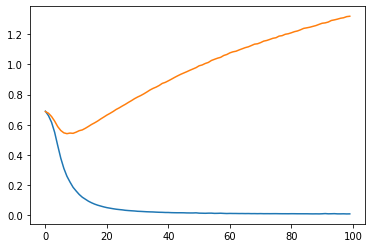

In [ ]:
train_loss= history.history['loss']
train_acc = history.history['acc']
val_loss  = history.history['val_loss']
val_acc   = history.history['val_acc']
xepoch = range(0,len(train_loss))
sns.lineplot(x=xepoch,y=train_loss)
sns.lineplot(x=xepoch,y=val_loss)

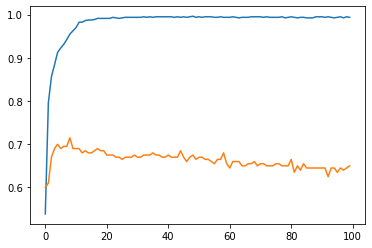

In [ ]:
sns.lineplot(x=xepoch,y=train_acc)
sns.lineplot(x=xepoch,y=val_acc)

##Conclusions/Comments
The embeddings vectorization of text is applied in this analysis, and the results are similar bag-of-words model. A more complex neural net, and larger dataset could improve the result.